In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# BRAIN TUMOR DETECTION

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
import os
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 94% 82.0M/86.8M [00:00<00:00, 162MB/s]
100% 86.8M/86.8M [00:00<00:00, 147MB/s]


In [ ]:
! unzip -d /content/drive/MyDrive/brain /content/brain-tumor-classification-mri.zip

Archive:  /content/brain-tumor-classification-mri.zip
  inflating: /content/drive/MyDrive/brain/Testing/glioma_tumor/image(1).jpg  
  inflating: /content/drive/MyDrive/brain/Testing/glioma_tumor/image(10).jpg  
  inflating: /content/drive/MyDrive/brain/Testing/glioma_tumor/image(100).jpg  
  inflating: /content/drive/MyDrive/brain/Testing/glioma_tumor/image(11).jpg  
  inflating: /content/drive/MyDrive/brain/Testing/glioma_tumor/image(12).jpg  
  inflating: /content/drive/MyDrive/brain/Testing/glioma_tumor/image(13).jpg  
  inflating: /content/drive/MyDrive/brain/Testing/glioma_tumor/image(14).jpg  
  inflating: /content/drive/MyDrive/brain/Testing/glioma_tumor/image(15).jpg  
  inflating: /content/drive/MyDrive/brain/Testing/glioma_tumor/image(16).jpg  
  inflating: /content/drive/MyDrive/brain/Testing/glioma_tumor/image(17).jpg  
  inflating: /content/drive/MyDrive/brain/Testing/glioma_tumor/image(18).jpg  
  inflating: /content/drive/MyDrive/brain/Testing/glioma_tumor/image(19).jpg 

## 3. Exploratory Data Analysis (EDA)

In [ ]:
# Changing our current directory and accesing the working directory
os.chdir('/content/drive/MyDrive/brain')


In [ ]:
# Train dataset directory
train_dir = "/content/drive/MyDrive/brain/Training"
# Class directories
number_classes = {'no_tumor': len(os.listdir("/content/drive/MyDrive/brain/Training/no_tumor")),
                  'glioma_tumor': len(os.listdir("/content/drive/MyDrive/brain/Training/glioma_tumor")),
                  'meningioma_tumor': len(os.listdir("/content/drive/MyDrive/brain/Training/meningioma_tumor")),
                  'pituitary_tumor': len(os.listdir("/content/drive/MyDrive/brain/Training/pituitary_tumor"))}

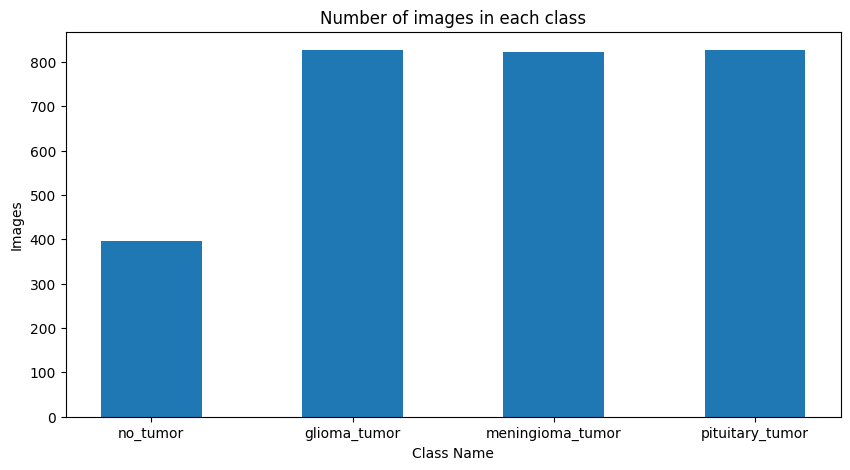

In [ ]:
# Class frequency plot
fig, ax = plt.subplots(figsize=(10, 5))

plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of images in each class");
plt.xlabel('Class Name');
plt.ylabel('Images');

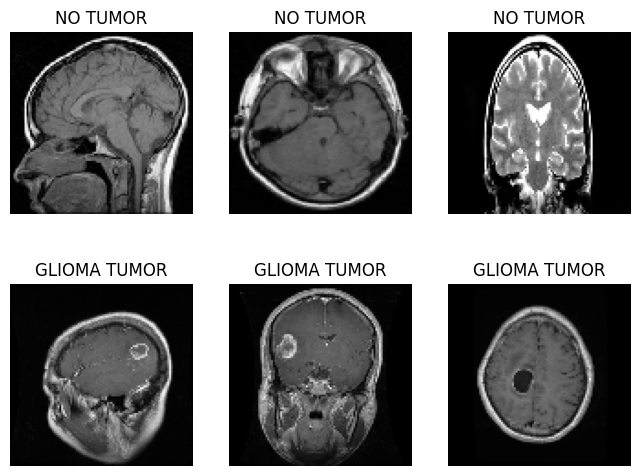

(395, 826)

In [ ]:
train_dir = "/content/drive/MyDrive/brain/Training" # image folder
# get the list of jpgs from sub image class folders
def get_images(base_dir, path, extenstion = ".jpg"):
  return [fn for fn in os.listdir(f'{base_dir}/{path}') if fn.endswith(extenstion)]

no_tumor_imgs = get_images(train_dir, "no_tumor")
glioma_imgs = get_images(train_dir, "glioma_tumor")
meningioma_imgs = get_images(train_dir, "meningioma_tumor")
pituitary_imgs = get_images(train_dir, "pituitary_tumor")

# randomly select 3 of each
def random_select(image):
  return np.random.choice(image, 3, replace = False)

select_no_tumor = random_select(no_tumor_imgs)
select_glioma = random_select(glioma_imgs)
select_meningioma = random_select(meningioma_imgs)
select_pituitary = random_select(pituitary_imgs)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/no_tumor/{select_no_tumor[i]}'
        label = 'NO TUMOR'
    else:
        fp = f'{train_dir}/glioma_tumor/{select_glioma[i-3]}'
        label = 'GLIOMA TUMOR'
    ax = fig.add_subplot(2, 3, i+1)

    # to plot without rescaling, remove target_size
    fn = load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

# also check the number of files here
len(no_tumor_imgs), len(glioma_imgs)


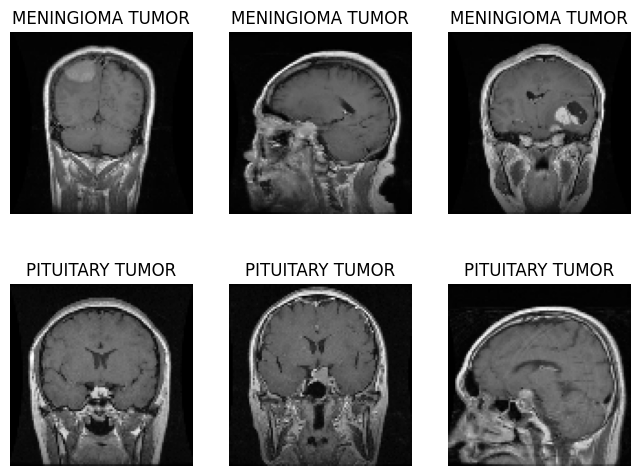

(822, 827)

In [ ]:
# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/meningioma_tumor/{select_meningioma[i]}'
        label = 'MENINGIOMA TUMOR'
    else:
        fp = f'{train_dir}/pituitary_tumor/{select_pituitary[i-3]}'
        label = 'PITUITARY TUMOR'
    ax = fig.add_subplot(2, 3, i+1)

    # to plot without rescaling, remove target_size
    fn = load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

# also check the number of files here
len(meningioma_imgs), len(pituitary_imgs)

In [ ]:
from keras.preprocessing import image


In [ ]:
# changing the image from a 2d to a 1d so that it can be read by the machine and the average of each group to be calculated.
# We create a function that runs through the folders, takes photos, turns them into a 1d from a 2d
#making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size,
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError:
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
no_tumor_images = img2np(f'{train_dir}/no_tumor/', no_tumor_imgs)
glioma_tumor_images = img2np(f'{train_dir}/glioma_tumor/', glioma_imgs)
meningioma_tumor_images = img2np(f'{train_dir}/meningioma_tumor/', meningioma_imgs)
pituitary_tumor_images = img2np(f'{train_dir}/pituitary_tumor/', pituitary_imgs)

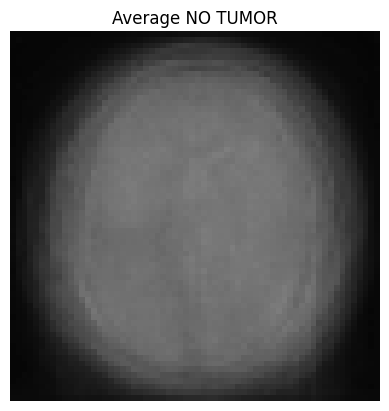

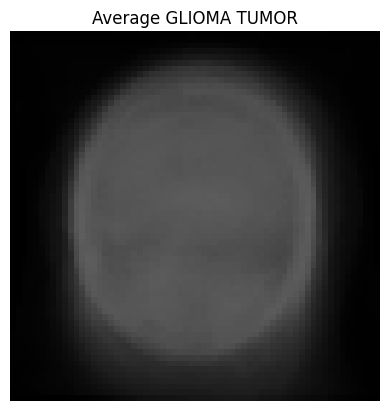

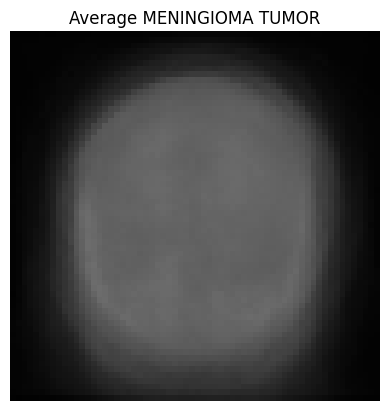

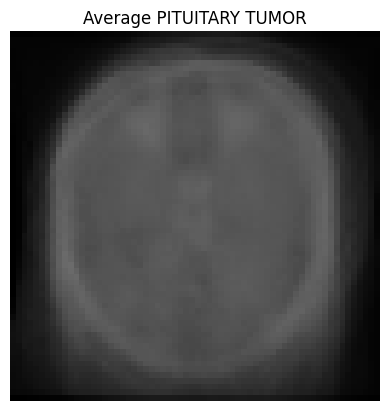

In [ ]:
# after converting the images t a 1D from a 2D, we create a fucntion that does the average of each category
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    fig.tight_layout()
    plt.show()
    return mean_img

no_tumor_mean = find_mean_img(no_tumor_images, 'NO TUMOR')
glioma_mean = find_mean_img(glioma_tumor_images, 'GLIOMA TUMOR')
meningioma_mean = find_mean_img(meningioma_tumor_images, 'MENINGIOMA TUMOR')
pituitary_mean = find_mean_img(pituitary_tumor_images, 'PITUITARY TUMOR')

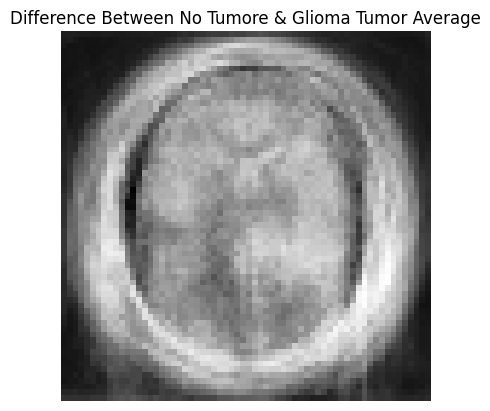

In [ ]:
contrast_mean = no_tumor_mean - glioma_mean
plt.imshow(contrast_mean, cmap='Greys_r')
plt.title(f'Difference Between No Tumore & Glioma Tumor Average')
plt.axis('off')
plt.show()

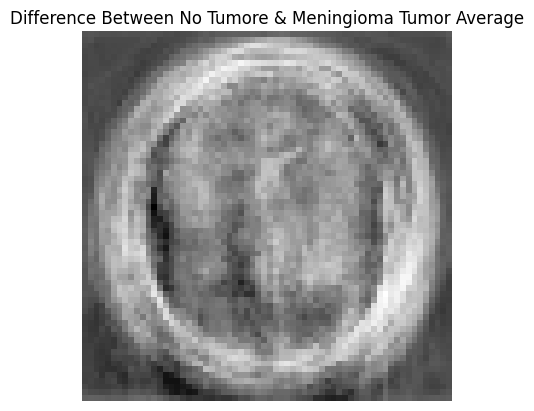

In [ ]:
contrast_mean = no_tumor_mean - meningioma_mean
plt.imshow(contrast_mean, cmap='Greys_r')
plt.title(f'Difference Between No Tumore & Meningioma Tumor Average')
plt.axis('off')
plt.show()

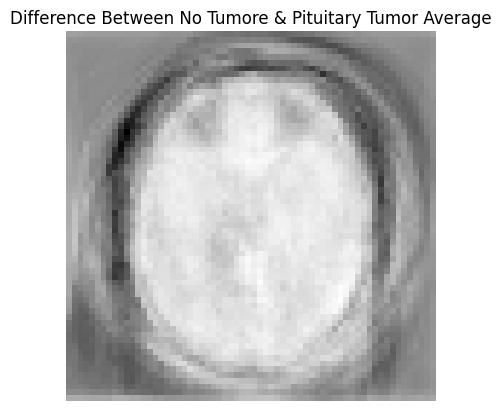

In [ ]:
contrast_mean = no_tumor_mean - pituitary_mean
plt.imshow(contrast_mean, cmap='Greys_r')
plt.title(f'Difference Between No Tumore & Pituitary Tumor Average')
plt.axis('off')
plt.show()

Number of PC:  43


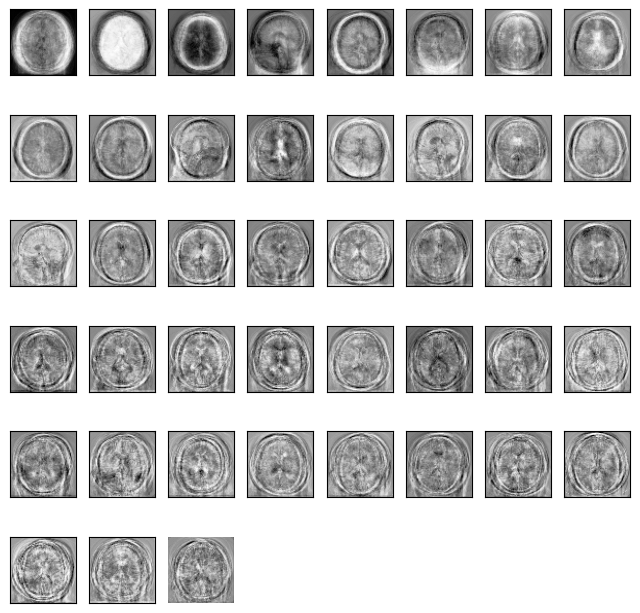

Number of PC:  82


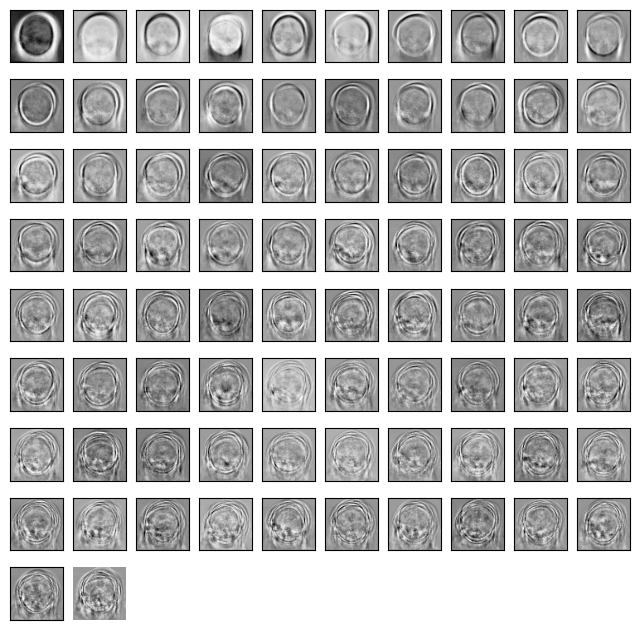

Number of PC:  63


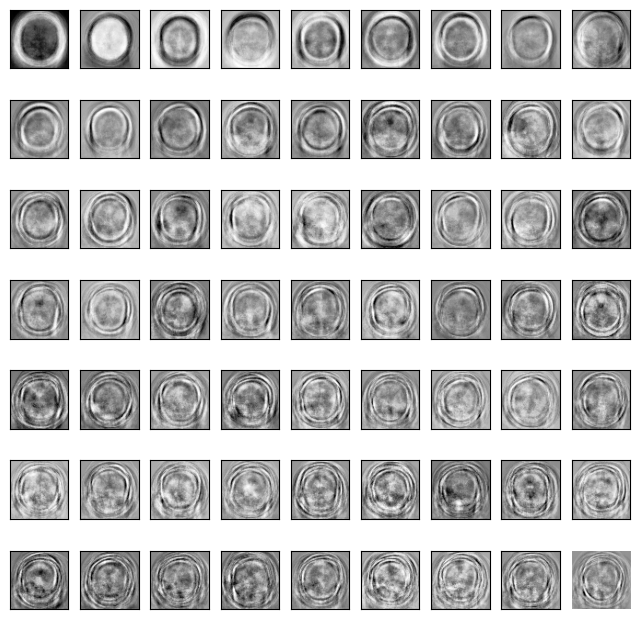

Number of PC:  73


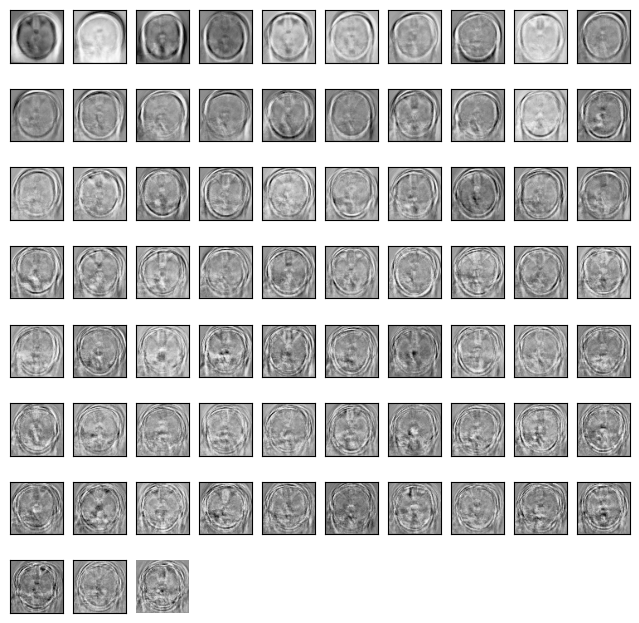

In [ ]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca

def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size),
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()

plot_pca(eigenimages(no_tumor_images, 'NO TUMOR'))
plot_pca(eigenimages(glioma_tumor_images, 'GLIOMA TUMOR'))
plot_pca(eigenimages(meningioma_tumor_images, 'MENINGIOMA TUMOR'))
plot_pca(eigenimages(pituitary_tumor_images, 'PITUITARY TUMOR'))

## 5. Modeling

### Train and test sets

In [ ]:
# Function used to generate the training and testing sets by combining all
# images into just a training and test set.
def train_test_1set(size, labels):
  # Train sets
  X_train, X_test, y_train, y_test = [], [], [], []
  # Folder paths
  # Training set
  for label in labels:
    folderPath = os.path.join('/content/drive/MyDrive/brain','Training',label)
    # Getting unique file names and using them to finish the file path
    # Display progress
    for unique in tqdm(os.listdir(folderPath)):
        # Reading images
        image = cv2.imread(os.path.join(folderPath, unique))
        # Set image size to the defined size
        image = cv2.resize(image,(size, size))
        # Appending the image to the X train set
        X_train.append(image)
        # Appending the label for the corresponding image
        y_train.append(label)

  # Testing set
  for label in labels:
      folderPath = os.path.join('/content/drive/MyDrive/brain','Testing',label)
      # Getting unique file names and using them to finish the file path
      # Display progress
      for unique in tqdm(os.listdir(folderPath)):
          # Reading the image
          image = cv2.imread(os.path.join(folderPath, unique))
          # Resizing the image according to the specified value
          image = cv2.resize(image,(size,size))
          # Appending the image to the train set
          X_train.append(image)
          # Appending the label of the correcponding image to the test set
          y_train.append(label)
          # Creating numpy arrays
  return X_train, y_train

In [ ]:
# Function used to generate the training and testing sets according to the
# original divisions.
def train_test_2sets(size, labels):
  # Train sets
  X_train, X_test, y_train, y_test = [], [], [], []
  # Folder paths
  # Training set
  for label in labels:
    folderPath = os.path.join('/content/drive/MyDrive/brain','Training',label)
    # Getting unique file names and using them to finish the file path
    # Display progress
    for unique in tqdm(os.listdir(folderPath)):
        # Reading images
        image = cv2.imread(os.path.join(folderPath, unique))
        # Set image size to the defined size
        image = cv2.resize(image,(size, size))
        # Appending the image to the X train set
        X_train.append(image)
        # Appending the label for the corresponding image
        y_train.append(label)

  # Testing set
  for label in labels:
      folderPath = os.path.join('/content/drive/MyDrive/brain','Testing',label)
      # Getting unique file names and using them to finish the file path
      # Display progress
      for unique in tqdm(os.listdir(folderPath)):
          # Reading the image
          image = cv2.imread(os.path.join(folderPath, unique))
          # Resizing the image according to the specified value
          image = cv2.resize(image,(size,size))
          # Appending the image to the train set
          X_test.append(image)
          # Appending the label of the correcponding image to the test set
          y_test.append(label)
          # Creating numpy arrays
  return X_train, X_test, y_train, y_test

In [ ]:
`# Image folder labels
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']`

# Funcion call
X_train, y_train = train_test_1set(150, labels)

100%|██████████| 74/74 [00:00<00:00, 76.85it/s]


In [ ]:
# Two sets
X2_train, X2_test, y2_train, y2_test = train_test_2sets(150, labels)

100%|██████████| 74/74 [00:00<00:00, 76.49it/s]


In [ ]:
# Converting to array
X_train = np.array(X_train)
y_train = np.array(y_train)
X2_train = np.array(X2_train)
X2_test = np.array(X2_test)
y2_train = np.array(y2_train)
y2_test = np.array(y2_test)
# Dataset shapes
print('Dataset shapes')
print(f'{"-"*30}\n')
print('First set:')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}\n')
print('Second set:')
print(f'X_train: {X2_train.shape}')
print(f'X_test: {X2_test.shape}')
print(f'y_train: {y2_train.shape}')
print(f'y_test: {y2_test.shape}')

Dataset shapes
------------------------------

First set:
X_train: (3264, 150, 150, 3)
y_train: (3264,)

Second set:
X_train: (2870, 150, 150, 3)
X_test: (394, 150, 150, 3)
y_train: (2870,)
y_test: (394,)


### Shuffling and Label Encoding

**Shuffling**

*First set*

In [ ]:
# Shuffling the training sets to randomize the order
X_train, y_train = shuffle(X_train, y_train, random_state=0)

Train-test-split

In [ ]:
# Train-test-split
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state = 0)

*Second Set*

In [ ]:
# Shuffling
X2_train, y2_train = shuffle(X2_train, y2_train, random_state = 0)
X2_test, y2_test = shuffle(X2_test, y2_test, random_state = 0)

**Encoding**

*Label Encoding*

In [ ]:
# Label encoding
y1_train = LabelEncoder().fit_transform(y_train)
y1_test = LabelEncoder().fit_transform(y_test)
y2_train = LabelEncoder().fit_transform(y2_train)
y2_test = LabelEncoder().fit_transform(y2_test)

*One-Hot Encoding*

In [ ]:
# One-Hot Encoding
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y3_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y3_test = tf.keras.utils.to_categorical(y_test)

### Convolutional Neural Networks

In [ ]:
# Model evaluation line plot
def History(hist):
  fig, ax = plt.subplots(figsize = (10, 5))
  plt.plot(hist.history['accuracy'], label = 'Accuracy')
  plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc = 'upper right')
  plt.show()

In [ ]:
from keras import models, layers


In [ ]:
# First CNN model function
def Model1(shape, labels, X_train, X_test, y_train, y_test, loss = 'sparse_categorical_crossentropy'):
  # Model definition
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation = 'relu',
            kernel_initializer = 'he_uniform', input_shape = shape))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  # print('CNN Layer Model Summary\n')
  # print(model.summary())
  # AddinG dense layers on top
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(len(labels), activation = 'softmax'))
  # Model summary
  # print('\nMLP Layer Model Summary\n')
  # print(model.summary())
  # Model Evaluation
  # Defining the loss and optimizer
  model.compile(optimizer = 'adam', loss = loss,
              metrics = ['accuracy'])
  # Fitting the model
  history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test))
  print('\nModel Evaluation\n')
  # Plotting the train and validation accuracy line graphs
  History(history)
  print()
  print()
  # Accuracy
  print('\nModel Accuracy and Loss\n')
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print(f'Test Accuracy: {test_acc}')
  print(f'TestLoss: {test_loss}')
  print()
  print()
  # Prediction
  pred = np.argmax(model.predict(X_test), axis = -1)
  # Classification report
  print('\nClassification Report\n')
  report = classification_report(y_test, pred)
  print(report)
  print()
  print()
  # Heatmap
  fig, ax = plt.subplots(figsize = (10, 8))
  sns.heatmap(confusion_matrix(y_test, pred), xticklabels=labels, yticklabels=labels,annot=True,
            cmap='viridis', fmt = 'g')
  plt.title('Heatmap', y = 1.05);




In [ ]:
# Second model function
def Model2(shape, labels, X_train, X_test, y_train, y_test, loss = 'categorical_crossentropy'):
  # Model definition
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation = 'relu',
            kernel_initializer = 'he_uniform', input_shape = shape))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  # print('CNN Layer Model Summary\n')
  # print(model.summary())
  # Adding dense layers on top
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(len(labels), activation = 'softmax'))
  # Model summary
  # print('\nMLP Layer Model Summary\n')
  # print(model.summary())
  # Model Evaluation
  # Defining the loss and optimizer
  model.compile(optimizer = 'adam', loss = loss,
              metrics = ['accuracy'])
  # Fitting the model
  history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test))
  print('\nModel Evaluation\n')
  # Plotting the train and validation accuracy ine plots
  History(history)
  print()
  print()
  # Accuracy
  print('\nModel Accuracy and Loss\n')
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print(f'Test Accuracy: {test_acc}')
  print(f'TestLoss: {test_loss}')
  print()
  print()
  # Prediction
  pred = model.predict(X_test)
  pred = np.argmax(pred,axis=1)
  y_test_new = np.argmax(y_test,axis=1)
  # Classification report
  print('\nClassification Report\n')
  report = classification_report(y_test_new, pred)
  print(report)
  print()
  print()
  # Heatmap
  fig, ax = plt.subplots(figsize = (10, 8))
  sns.heatmap(confusion_matrix(y_test_new, pred), xticklabels=labels, yticklabels=labels,annot=True,
            cmap='viridis', fmt = 'g')
  plt.title('Heatmap', y = 1.05);




In [ ]:
# Input features shape
shape = X_train.shape[1:]
shape

(150, 150, 3)

**First Model**

Epoch 1/50
92/92 [==============================] - 16s 30ms/step - loss: 22.1382 - accuracy: 0.2901 - val_loss: 1.3782 - val_accuracy: 0.3364
Epoch 2/50
92/92 [==============================] - 2s 21ms/step - loss: 1.3805 - accuracy: 0.2778 - val_loss: 1.3728 - val_accuracy: 0.3364
Epoch 3/50
92/92 [==============================] - 2s 22ms/step - loss: 1.3718 - accuracy: 0.2642 - val_loss: 1.3679 - val_accuracy: 0.2508
Epoch 4/50
92/92 [==============================] - 2s 23ms/step - loss: 1.3686 - accuracy: 0.2911 - val_loss: 1.3641 - val_accuracy: 0.2508
Epoch 5/50
92/92 [==============================] - 2s 21ms/step - loss: 1.3648 - accuracy: 0.2911 - val_loss: 1.3616 - val_accuracy: 0.2508
Epoch 6/50
92/92 [==============================] - 2s 20ms/step - loss: 1.3629 - accuracy: 0.2911 - val_loss: 1.3600 - val_accuracy: 0.2508
Epoch 7/50
92/92 [==============================] - 2s 21ms/step - loss: 1.3615 - accuracy: 0.2911 - val_loss: 1.3589 - val_accuracy: 0.2508
Epoch 8/50


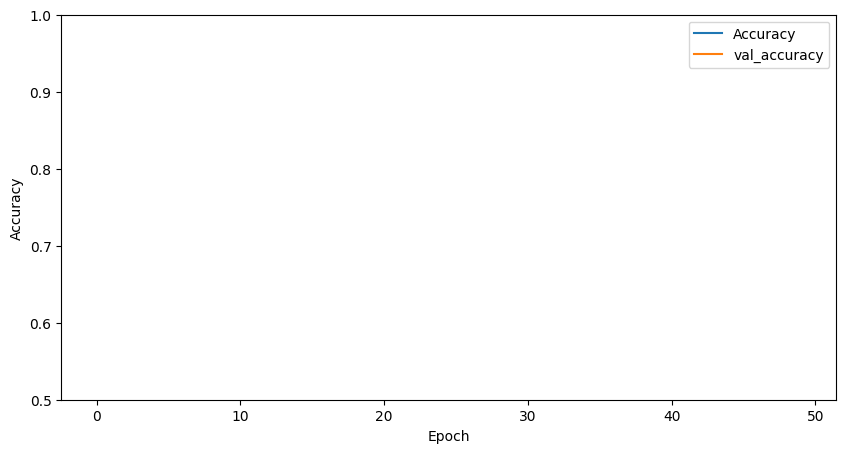




Model Accuracy and Loss

11/11 [==============================] - 0s 10ms/step - loss: 1.3565 - accuracy: 0.2508
Test Accuracy: 0.25076451897621155
TestLoss: 1.3565139770507812


11/11 [==============================] - 0s 8ms/step

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       110
           1       0.25      1.00      0.40        82
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        87

    accuracy                           0.25       327
   macro avg       0.06      0.25      0.10       327
weighted avg       0.06      0.25      0.10       327





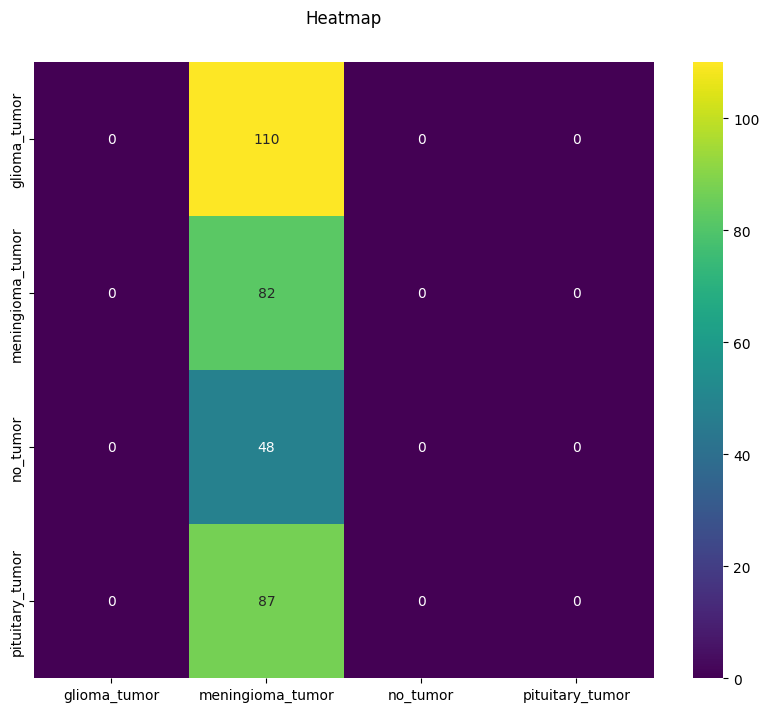

In [ ]:
# 1st dataset, label encoded target
Model1(shape, labels, X_train, X_test, y1_train, y1_test)

**Second Model**

Epoch 1/50
90/90 [==============================] - 5s 29ms/step - loss: 13.1813 - accuracy: 0.4892 - val_loss: 2.0331 - val_accuracy: 0.3553
Epoch 2/50
90/90 [==============================] - 2s 21ms/step - loss: 0.8508 - accuracy: 0.6544 - val_loss: 2.6689 - val_accuracy: 0.4518
Epoch 3/50
90/90 [==============================] - 2s 21ms/step - loss: 0.7281 - accuracy: 0.7230 - val_loss: 2.6933 - val_accuracy: 0.5203
Epoch 4/50
90/90 [==============================] - 2s 22ms/step - loss: 0.6087 - accuracy: 0.7638 - val_loss: 2.9190 - val_accuracy: 0.5457
Epoch 5/50
90/90 [==============================] - 2s 23ms/step - loss: 0.5317 - accuracy: 0.7854 - val_loss: 2.1882 - val_accuracy: 0.6142
Epoch 6/50
90/90 [==============================] - 2s 21ms/step - loss: 0.4565 - accuracy: 0.8226 - val_loss: 2.8445 - val_accuracy: 0.5888
Epoch 7/50
90/90 [==============================] - 2s 21ms/step - loss: 0.4463 - accuracy: 0.8195 - val_loss: 3.6122 - val_accuracy: 0.6193
Epoch 8/50
9

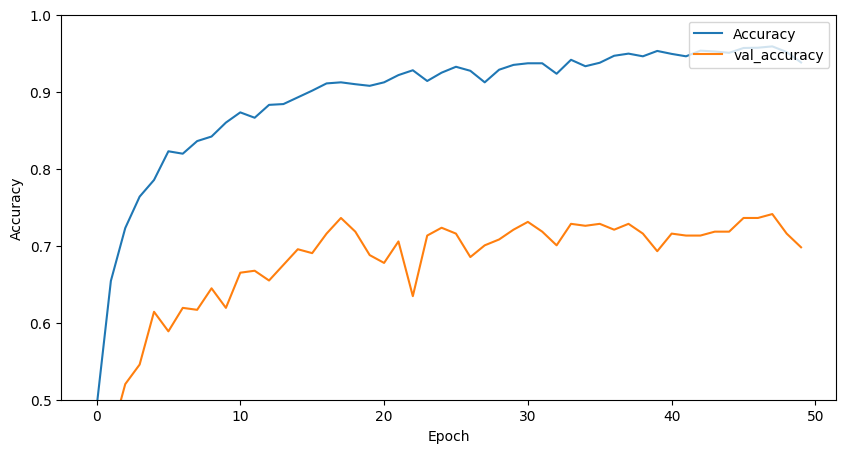




Model Accuracy and Loss

13/13 [==============================] - 0s 8ms/step - loss: 7.6319 - accuracy: 0.6980
Test Accuracy: 0.6979695558547974
TestLoss: 7.631906032562256


13/13 [==============================] - 0s 6ms/step

Classification Report

              precision    recall  f1-score   support

           0       0.83      0.19      0.31       100
           1       0.72      0.94      0.82       115
           2       0.60      1.00      0.75       105
           3       0.96      0.58      0.72        74

    accuracy                           0.70       394
   macro avg       0.77      0.68      0.65       394
weighted avg       0.76      0.70      0.65       394





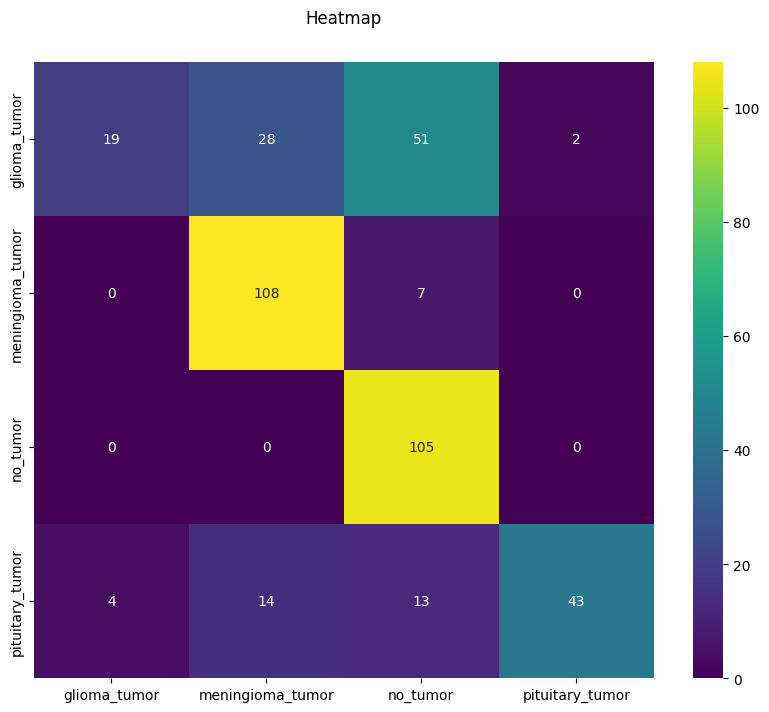

In [ ]:
# 2nd dataset, label encoded target
Model1(shape, labels, X2_train, X2_test, y2_train, y2_test, loss = 'sparse_categorical_crossentropy')

**Third Model**

Epoch 1/50
92/92 [==============================] - 5s 28ms/step - loss: 14.9587 - accuracy: 0.4522 - val_loss: 0.9826 - val_accuracy: 0.5810
Epoch 2/50
92/92 [==============================] - 2s 22ms/step - loss: 0.9552 - accuracy: 0.5928 - val_loss: 0.8643 - val_accuracy: 0.6453
Epoch 3/50
92/92 [==============================] - 2s 21ms/step - loss: 0.7454 - accuracy: 0.6977 - val_loss: 0.8347 - val_accuracy: 0.7064
Epoch 4/50
92/92 [==============================] - 2s 20ms/step - loss: 0.6394 - accuracy: 0.7351 - val_loss: 0.8257 - val_accuracy: 0.7339
Epoch 5/50
92/92 [==============================] - 2s 21ms/step - loss: 0.6210 - accuracy: 0.7555 - val_loss: 0.8012 - val_accuracy: 0.7554
Epoch 6/50
92/92 [==============================] - 2s 22ms/step - loss: 0.5138 - accuracy: 0.7886 - val_loss: 0.8422 - val_accuracy: 0.8104
Epoch 7/50
92/92 [==============================] - 2s 22ms/step - loss: 0.4729 - accuracy: 0.8131 - val_loss: 0.7658 - val_accuracy: 0.7829
Epoch 8/50
9

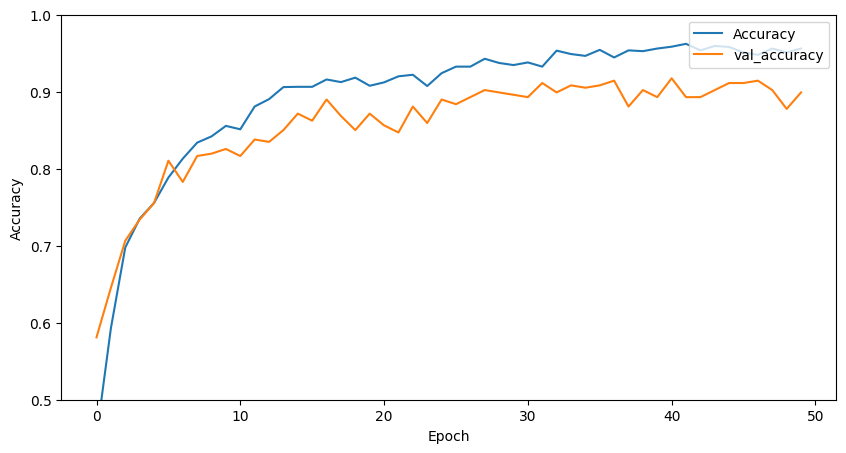




Model Accuracy and Loss

11/11 [==============================] - 0s 10ms/step - loss: 1.1850 - accuracy: 0.8991
Test Accuracy: 0.8990825414657593
TestLoss: 1.1850007772445679


11/11 [==============================] - 0s 8ms/step

Classification Report

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       110
           1       0.79      0.93      0.85        82
           2       0.93      0.83      0.88        48
           3       0.94      0.97      0.95        87

    accuracy                           0.90       327
   macro avg       0.90      0.90      0.90       327
weighted avg       0.91      0.90      0.90       327





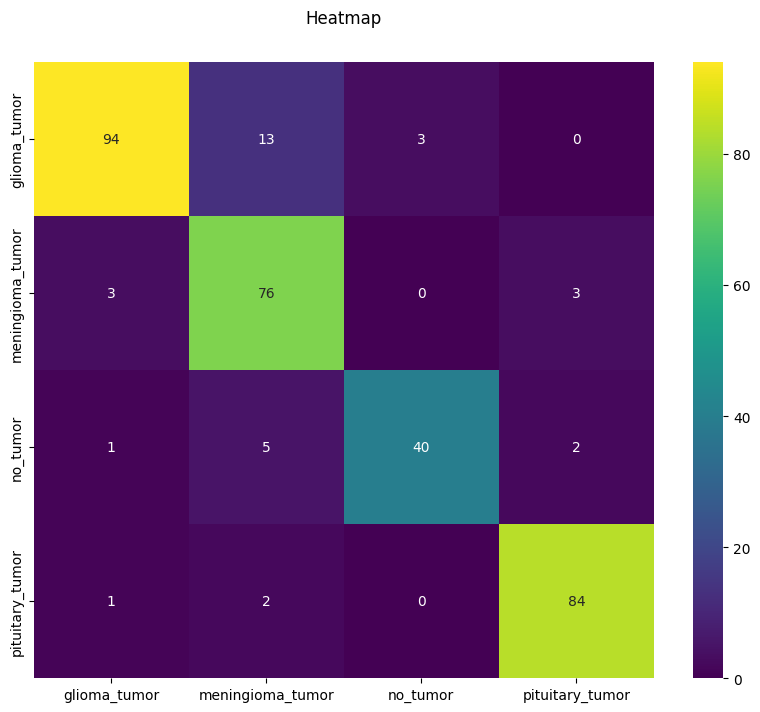

In [ ]:
# 1st dataset, one hot encoded target
Model2(shape, labels, X_train, X_test, y3_train, y3_test, loss = 'categorical_crossentropy')

**Fourth Model**

In [ ]:
# CNN function for the second model
def Model3(shape, labels, X_train, X_test, y_train, y_test, loss = 'categorical_crossentropy'):
  # Model definition
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape= shape))
  model.add(layers.MaxPool2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(len(labels), activation='softmax'))
  # Defining the loss and optimizer
  model.compile(optimizer='adam', loss= loss, metrics=['accuracy'])
  # Fitting the model
  history = model.fit(X_train, y_train, epochs=50, batch_size=128)
  # Accuracy
  print('\nModel Accuracy and Loss\n')
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print(f'Test Accuracy: {test_acc}')
  print(f'TestLoss: {test_loss}')
  print()
  print()
  # Prediction
  pred = model.predict(X_test)
  pred = np.argmax(pred,axis=1)
  y_test_new = np.argmax(y_test,axis=1)
  # Classification report
  print('\nClassification Report\n')
  report = classification_report(y_test_new, pred)
  print(report)
  print()
  print()
  # Heatmap
  fig, ax = plt.subplots(figsize = (10, 8))
  sns.heatmap(confusion_matrix(y_test_new, pred), xticklabels=labels, yticklabels=labels,annot=True,
            cmap='viridis', fmt = 'g')
  plt.title('Heatmap', y = 1.05);



Epoch 1/50
23/23 [==============================] - 2s 38ms/step - loss: 1420.9858 - accuracy: 0.2966
Epoch 2/50
23/23 [==============================] - 1s 36ms/step - loss: 1.4377 - accuracy: 0.2775
Epoch 3/50
23/23 [==============================] - 1s 37ms/step - loss: 1.3830 - accuracy: 0.2778
Epoch 4/50
23/23 [==============================] - 1s 36ms/step - loss: 1.3810 - accuracy: 0.2778
Epoch 5/50
23/23 [==============================] - 1s 36ms/step - loss: 1.3790 - accuracy: 0.2761
Epoch 6/50
23/23 [==============================] - 1s 38ms/step - loss: 1.3770 - accuracy: 0.2911
Epoch 7/50
23/23 [==============================] - 1s 38ms/step - loss: 1.3753 - accuracy: 0.2911
Epoch 8/50
23/23 [==============================] - 1s 40ms/step - loss: 1.3736 - accuracy: 0.2911
Epoch 9/50
23/23 [==============================] - 1s 40ms/step - loss: 1.3721 - accuracy: 0.2911
Epoch 10/50
23/23 [==============================] - 1s 39ms/step - loss: 1.3707 - accuracy: 0.2911
Epoch 

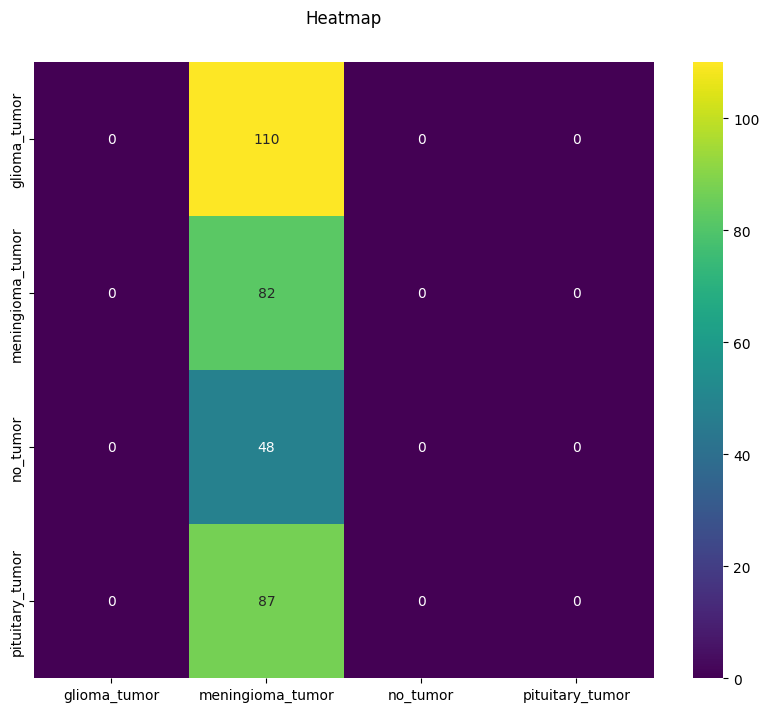

In [ ]:
# Function call
Model3(shape, labels, X_train, X_test, y3_train, y3_test, loss = 'categorical_crossentropy')

Function definition

In [ ]:
# Pre-trained model
def pre_trained_performance(shape, labels, X_train, X_test, y_train, y_test):
  # Pre-trained model
  efficient_net = EfficientNetB0(input_shape = shape, weights='imagenet',include_top=False)
  # Model definition
  model = efficient_net.output
  model = tf.keras.layers.GlobalAveragePooling2D()(model)
  model = tf.keras.layers.Dropout(rate=0.5)(model)
  model = tf.keras.layers.Dense(4,activation='softmax')(model)
  model = tf.keras.models.Model(inputs=efficient_net.input, outputs = model)
  # Model summary
  # model.summary()
  # Compiling the model
  model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])
  # Model fit
  history = model.fit(X_train,y3_train,validation_data = (X_test, y3_test), epochs =52, verbose=1, batch_size=32)
  print('\nModel Evaluation\n')
  History(history)
  print()
  print()
  # Accuracy
  print('\nModel Accuracy and Loss\n')
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print(f'Test Accuracy: {test_acc}')
  print(f'TestLoss: {test_loss}')
  print()
  print()
  # Prediction
  pred = model.predict(X_test)
  pred = np.argmax(pred,axis=1)
  y_test_new = np.argmax(y_test,axis=1)
  # Classification report
  print('\nClassification Report\n')
  report = classification_report(y_test_new, pred)
  print(report)
  print()
  print()
  # Heatmap
  fig, ax = plt.subplots(figsize = (10, 8))
  sns.heatmap(confusion_matrix(y_test_new, pred), xticklabels=labels, yticklabels=labels,annot=True,
            cmap='viridis', fmt = 'g')
  plt.title('Heatmap', y = 1.05);


In [ ]:
# Saving the original model and a tflite model
def save_pretrained_model(shape, X_train, X_test, y_train, y_test):
  # Pre-trained model
  efficient_net = EfficientNetB0(input_shape = shape, weights='imagenet',include_top=False)
  # Model definition
  model = efficient_net.output
  model = tf.keras.layers.GlobalAveragePooling2D()(model)
  # Reduce overfitting
  model = tf.keras.layers.Dropout(rate=0.5)(model)
  model = tf.keras.layers.Dense(4,activation='softmax')(model)
  model = tf.keras.models.Model(inputs=efficient_net.input, outputs = model)
  # Compiling the model
  model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])
  # Callbacks
  # Saving the logs
  tensorboard = TensorBoard(log_dir = 'logs')
  #Saving the model
  checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
  # Reduce learning rate once learning stagnates
  reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                                mode='auto',verbose=1)
  # Model fitting
  model.fit(X_train,y3_train,validation_data = (X_test, y3_test), epochs =52, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  # Converting the model to a tflite model
  tflite_model = converter.convert()

  # Saving the tflite model
  with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/52
92/92 [==============================] - 64s 181ms/step - loss: 0.4240 - accuracy: 0.8393 - val_loss: 0.7327 - val_accuracy: 0.8104
Epoch 2/52
92/92 [==============================] - 12s 133ms/step - loss: 0.1752 - accuracy: 0.9367 - val_loss: 0.2933 - val_accuracy: 0.9266
Epoch 3/52
92/92 [==============================] - 13s 139ms/step - loss: 0.1326 - accuracy: 0.9547 - val_loss: 0.6161 - val_accuracy: 0.8349
Epoch 4/52
92/92 [==============================] - 12s 135ms/step - loss: 0.1123 - accuracy: 0.9646 - val_loss: 0.2724 - val_accuracy: 0.9266
Epoch 5/52
92/92 [==============================] - 13s 138ms/step - loss: 0.0864 - accuracy: 0.9721 - val_loss: 0.1230 - val_accuracy: 0.9664
Epoch 6/52
92/92 [==============================] - 16s 174ms/step - loss: 0.0543 - accuracy: 0.9857 - val_loss: 0.2025 - val_accuracy: 0.9419
Epoch 7/52
92/92 [==============================] - 12s 136ms/step - loss: 0.

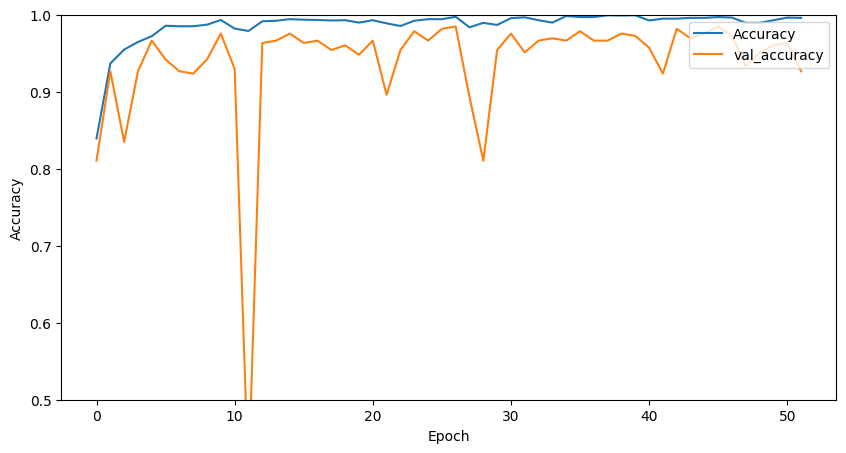




Model Accuracy and Loss

11/11 [==============================] - 0s 40ms/step - loss: 0.3834 - accuracy: 0.9266
Test Accuracy: 0.9266055226325989
TestLoss: 0.3833965063095093


11/11 [==============================] - 3s 38ms/step

Classification Report

              precision    recall  f1-score   support

           0       1.00      0.87      0.93       110
           1       0.95      0.88      0.91        82
           2       0.92      1.00      0.96        48
           3       0.84      1.00      0.92        87

    accuracy                           0.93       327
   macro avg       0.93      0.94      0.93       327
weighted avg       0.93      0.93      0.93       327





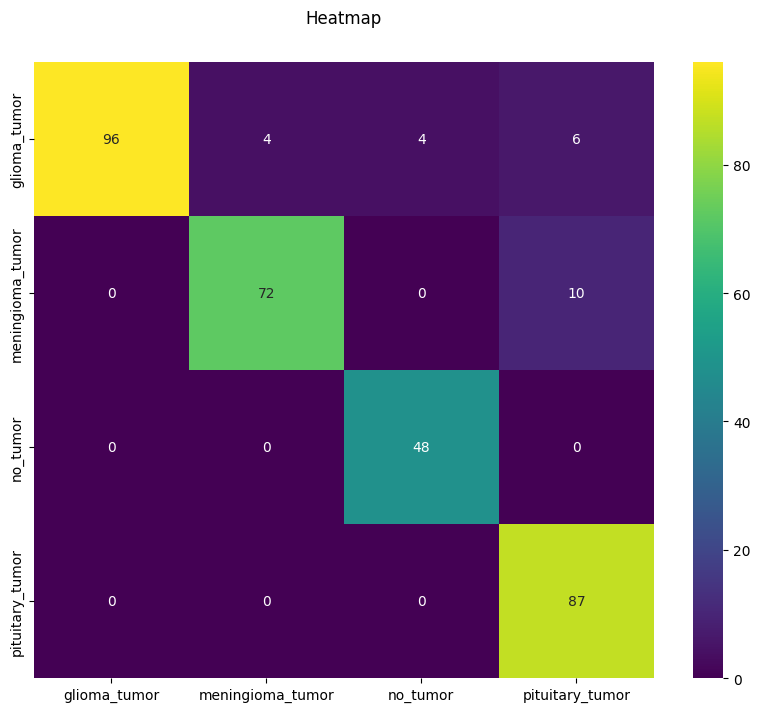

In [ ]:
# Employing the pretrained model
pre_trained_performance(shape, labels, X_train, X_test, y3_train, y3_test)

In [ ]:
# Saving the original model, as well as the tflite model
save_pretrained_model(shape, X_train, X_test, y3_train, y3_test)

Epoch 1/52
92/92 [==============================] - ETA: 0s - loss: 0.4796 - accuracy: 0.8264
Epoch 1: val_accuracy improved from -inf to 0.88991, saving model to effnet.h5
92/92 [==============================] - 62s 171ms/step - loss: 0.4796 - accuracy: 0.8264 - val_loss: 0.3609 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 2/52
92/92 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.9231
Epoch 2: val_accuracy improved from 0.88991 to 0.89602, saving model to effnet.h5
92/92 [==============================] - 14s 155ms/step - loss: 0.2132 - accuracy: 0.9231 - val_loss: 0.2720 - val_accuracy: 0.8960 - lr: 0.0010
Epoch 3/52
92/92 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9598
Epoch 3: val_accuracy improved from 0.89602 to 0.94495, saving model to effnet.h5
92/92 [==============================] - 14s 155ms/step - loss: 0.1187 - accuracy: 0.9598 - val_loss: 0.1509 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 4/52
92/92 [======================

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model("effnet.h5")  # Replace with the actual file path

# Now, you can use the imported model for various tasks, such as prediction or further training.


In [ ]:
model.save("brain.h5")

### b). Do we need other data to answer our question?

Yes, more data will improve the prediction accuracy of the model, as more patterns will be derived from varying images. Furthermore, more data can be used to rectify the class imbalance, in order to reduce model prediction bias.


### c). Did we have the right question?

Yes, as implementation of its solution has led to the development of a model with a high accuracy of 96 - 97%, F1 scores > 90% and precision scores >= 93%.


